In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import poisson
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score


In [6]:
def encode_visual_input(visual_positions, visual_variance, n_neurons=76):
    """
    Encode visual information using receptive field-like population coding
    
    Parameters:
    -----------
    visual_positions : array
        Visual positions to encode
    visual_variance : array
        Variance of the visual information
    n_neurons : int
        Number of neurons in the visual sensory group
        
    Returns:
    --------
    visual_activations : array
        Activations of visual neurons
    """
    N = len(visual_positions)
    visual_field_range = (-75, 75)  
    sigma_rf = 10  # Width of receptive field in degrees
    K = 50  # Gain factor constant
    
    # Calculate the receptive field centers for each neuron
    delta_x = (visual_field_range[1] - visual_field_range[0]) / (n_neurons - 1)
    receptive_field_centers = np.linspace(visual_field_range[0], visual_field_range[1], n_neurons)
    
    # Initialize visual activations
    visual_activations = np.zeros((n_neurons, N))
    
    # Calculate firing rates based on Gaussian tuning curves
    for i in range(n_neurons):
        firing_rates = np.exp(-((visual_positions - receptive_field_centers[i])**2) / (2 * sigma_rf**2))
        
        gain_factor = K / ( 1+visual_variance)
        adjusted_rates = firing_rates * gain_factor
        
        # Add Poisson noise
        for j in range(N):
            visual_activations[i, j] = np.random.poisson(adjusted_rates[j])
    
    return visual_activations

def encode_proprioceptive_input(positions, variance, input_type="hand", n_neurons=76):
    """
    Encode proprioceptive information (hand or eye) using muscle-like tuning
    
    Parameters:
    -----------
    positions : array
        Positions to encode
    variance : array
        Variance of the information
    input_type : str
        Type of proprioceptive input ('hand' or 'eye')
    n_neurons : int
        Number of neurons
        
    Returns:
    --------
    activations : array
        Activations of proprioceptive neurons
    """
    N = len(positions)
    max_value= np.max(np.abs(positions))
    K = 50  # Gain factor constant
    
    # Initialize activations
    activations = np.zeros((n_neurons, N))
    
    # Generate random intercepts and slopes for each neuron
    # intercepts in (-1, 1) and slopes in (-10, 10)
    np.random.seed(42 if input_type == "hand" else 43)  # Different seeds for hand and eye
    intercepts = np.random.uniform(-1, 1, n_neurons)
    slopes = np.random.uniform(-10, 10, n_neurons)
    np.random.seed(None)  # Reset seed
    
    # Calculate firing rates based on linear tuning
    for i in range(n_neurons):
        # Linear tuning with rectification ([]+)
        firing_rates = np.maximum(0, intercepts[i] + (slopes[i] * positions)/max_value)
        
        gain_factor = K / (1+variance)
        adjusted_rates = firing_rates * gain_factor
        
        # Add Poisson noise
        for j in range(N):
            activations[i, j] = np.random.poisson(adjusted_rates[j])
    
    return activations


def create_dataset(N=50000, train_ratio=0.8, xp=1):
    """
    Create the dataset with proper sensory input encoding.
    
    Parameters:
    -----------
    N : int
        Length of dataset
    train_ratio : float
        Ratio of training data to total data
    xp : int
        1 if sources are from a common cause, 0 if sources are independent
        
    Returns:
    --------
    train_X : array
        Training inputs (neural activations)
    test_X : array
        Testing inputs (neural activations)
    train_y : array
        Training outputs
    test_y : array
        Testing outputs
    """
    # Create basic input positions
    input_pos = np.zeros((3, N))  # Creating input position array
    input_pos[0, :] = 15 * np.random.randn(N)  # Random set of retinal hand position
    input_pos[1, :] = input_pos[0, :] + 10 * np.random.randn(N)  # Random set of associated eye position 
    input_pos[2, :] = input_pos[1, :] + 10 * np.random.randn(N)  # Random set of associated proprioceptive hand position

    # Create variances
    VarVis = (np.abs(np.random.randn(N) + 2) + 1) ** 2  # Visual variance
    VarPro = (np.abs(np.random.randn(N) + 3) + 1) ** 2  # Proprioceptive variance
    VarEye = (np.abs(np.random.randn(N) + 2) + 1) ** 2 # Eye Position variance (assumed to be 0 in the description)
    
    # Causal inference - probability of common cause
    P_common = np.exp(-((input_pos[0, :] + input_pos[1,:] - input_pos[2, :]) ** 2) / (2 * (VarEye + VarVis + VarPro)))

    # Bayesian integration mapping
    VarTot = (VarVis + VarEye) * VarPro / (VarVis + VarEye + VarPro)
    output_fused = VarTot * ((input_pos[0, :] + input_pos[1, :]) / (VarVis + VarEye) + input_pos[2, :] / VarPro)

    # Simple input-output mapping
    VarOut_v = (VarVis + VarEye)
    VarOut_p = VarPro
    output_v = (input_pos[0, :] + input_pos[1, :])
    output_p = input_pos[2, :]
    
    if xp == 1:  # Sources are from a common cause
        output_v_total = P_common * output_fused + (1-P_common) * output_v
        output_p_total = P_common * output_fused + (1-P_common) * output_p
        VarOut_p_total = P_common * VarTot + (1-P_common) * VarPro
        VarOut_v_total = P_common * VarTot + (1-P_common) * VarOut_v
    else:  # Sources are independent
        output_v_total = output_v
        output_p_total = output_p
        VarOut_p_total = VarOut_p
        VarOut_v_total = VarOut_v

    # output_separate = np.vstack((input_pos[0, :], input_pos[2, :]))  
    # output = P_common * output_fused + (1 - P_common) * output_separate.mean(axis=0)
    
    # Now encode these inputs using the neural encoding
    
    # 1. Visual information encoding with receptive field-like population coding
    visual_input = encode_visual_input(input_pos[0, :], VarVis)
    
    # 2. Proprioceptive information of hand position with muscle-like tuning
    prop_hand_input = encode_proprioceptive_input(input_pos[2, :], VarPro, input_type="hand")
    
    # 3. Proprioceptive information of eye position with muscle-like tuning
    eye_input = encode_proprioceptive_input(input_pos[1, :], VarEye, input_type="eye")
    
    X = np.vstack((visual_input, prop_hand_input, eye_input))
    
    # Prepare outputs
    y = {
        'output_v_total': output_v_total,
        'output_p_total': output_p_total,
        'var_out_v_total': VarOut_v_total,
        'var_out_p_total': VarOut_p_total
    }
    
    # Split into training and testing sets
    train_indices = np.arange(train_size)
    test_indices = np.arange(train_size, N)
    
    train_X = X[:, train_indices]
    test_X = X[:, test_indices]
    
    train_y = {key: value[train_indices] for key, value in y.items()}
    test_y = {key: value[test_indices] for key, value in y.items()}
    
    return train_X, test_X, train_y, test_y


def visualize_network_inputs(train_X, n_samples=10, save_path=None):
    """
    Visualize sample network inputs
    
    Parameters:
    -----------
    train_X : array
        Training inputs
    n_samples : int
        Number of samples to visualize
    save_path : str, optional
        Path to save the visualization
    """
    n_visual = 76
    n_prop = 76
    n_eye = 76
    
    # Get visualization samples
    vis_samples = train_X[:n_visual, :n_samples]
    prop_samples = train_X[n_visual:n_visual+n_prop, :n_samples]
    eye_samples = train_X[n_visual+n_prop:, :n_samples]
    
    # Create plot
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 1, 1)
    plt.title("Visual Input Layer Activations (5 Samples)", fontsize=14)
    plt.imshow(vis_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Visual Neuron", fontsize=12)
    
    plt.subplot(3, 1, 2)
    plt.title("Proprioceptive Hand Input Layer Activations", fontsize=14)
    plt.imshow(prop_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Proprioceptive Hand Neuron", fontsize=12)
    
    plt.subplot(3, 1, 3)
    plt.title("Eye Position Input Layer Activations", fontsize=14)
    plt.imshow(eye_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Eye Position Neuron", fontsize=12)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return plt.gcf()


Creating dataset with neural encoding...

Dataset creation complete!
Training input shape: (228, 40000)
Testing input shape: (228, 10000)

Input layer consists of:
  - 76 visual neurons (indices 0-75)
  - 76 proprioceptive hand neurons (indices 76-152)
  - 76 eye position neurons (indices 152-228)
Total: 228 input neurons

Outputs available:
  - output_v_total: shape (40000,)
  - output_p_total: shape (40000,)
  - var_out_v_total: shape (40000,)
  - var_out_p_total: shape (40000,)

Creating visualization of sample network inputs...
Visualization saved to 'network_inputs.png'


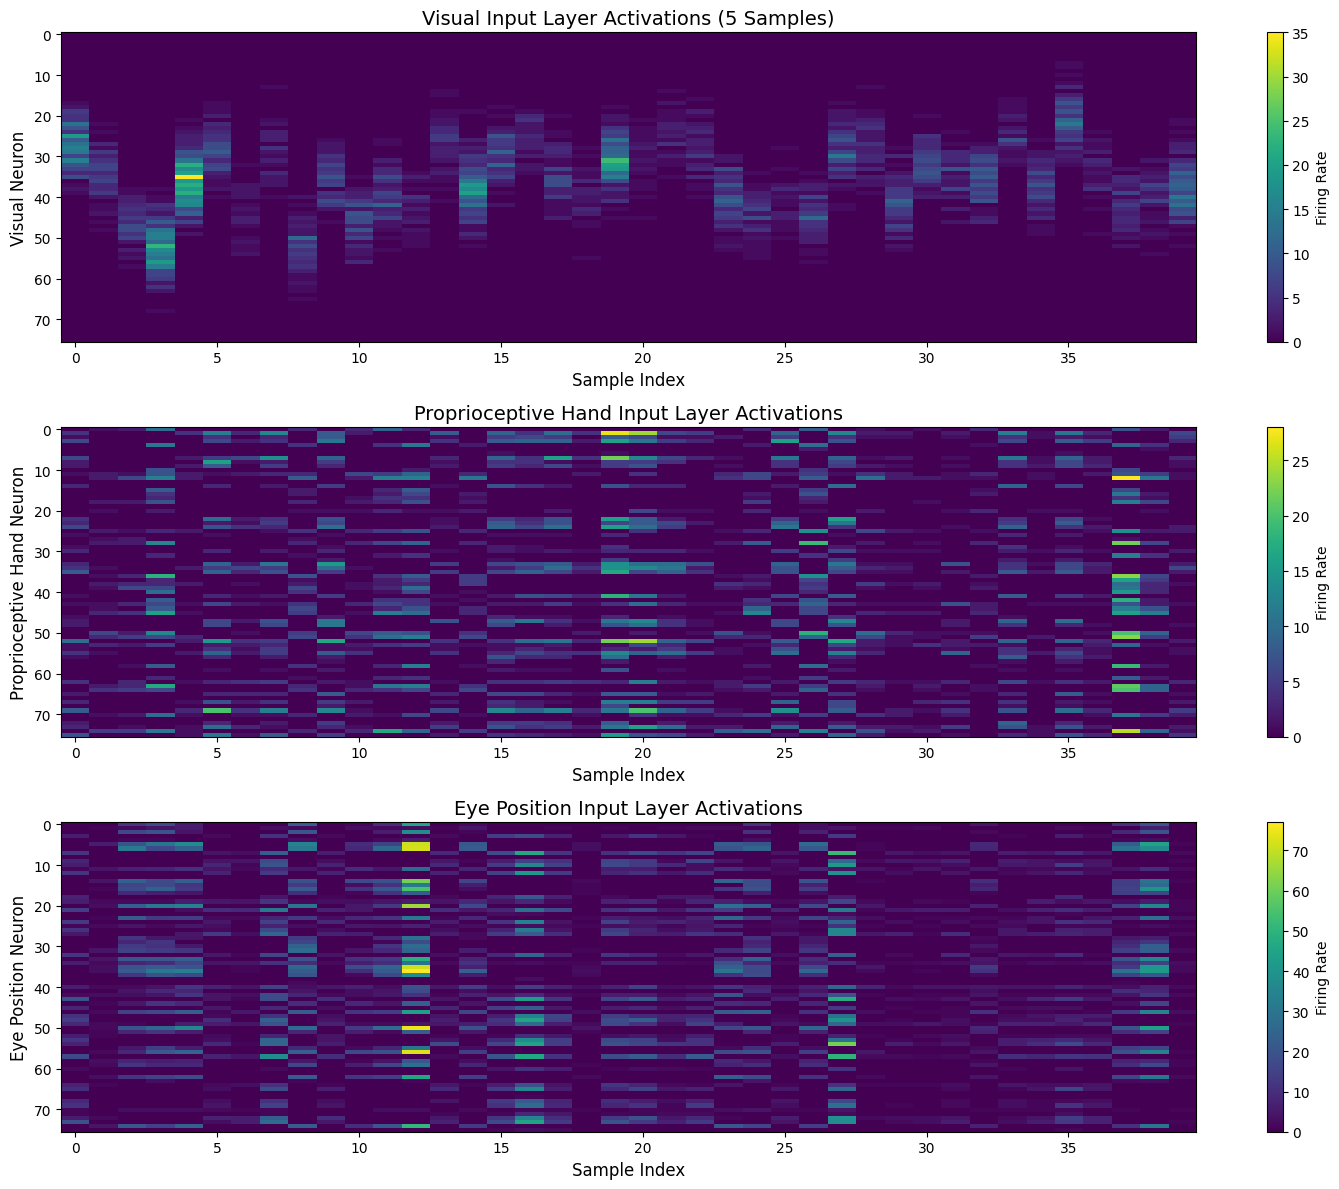

In [16]:

xp = 1 #Sources are from a common cause  # xp = 0 Sources are independent
# Creating the dataset
N = 50000  # length of dataset
train_ratio = 0.8  # 80% for training

def main():
    print("Creating dataset with neural encoding...")
    train_X, test_X, train_y, test_y = create_dataset(N=50000, train_ratio=0.8, xp=1)
    
    print("\nDataset creation complete!")
    print(f"Training input shape: {train_X.shape}")
    print(f"Testing input shape: {test_X.shape}")
    
    print("\nInput layer consists of:")
    print(f"  - {76} visual neurons (indices 0-75)")
    print(f"  - {76} proprioceptive hand neurons (indices 76-152)")
    print(f"  - {76} eye position neurons (indices 152-228)")
    print(f"Total: {train_X.shape[0]} input neurons")
    
    print("\nOutputs available:")
    for key in train_y.keys():
        print(f"  - {key}: shape {train_y[key].shape}")
    
    # Visualize sample network inputs
    print("\nCreating visualization of sample network inputs...")
    visualize_network_inputs(train_X, n_samples=40, save_path="network_inputs.png")
    print("Visualization saved to 'network_inputs.png'")
    
    # Return dataset for further use
    return train_X, test_X, train_y, test_y

if __name__ == "__main__":
    train_X, test_X, train_y, test_y = main()

###### A simple review on what model we have :                          
    prop -->                                  ----> out_p
              FC1  |  FC2  |  out put layer    
    vis  -->                                  ----> out_v
    


In [17]:

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

def train_and_evaluate_model(train_X, test_X, train_y, test_y, batch_size=128, 
                             hidden1_size=256, hidden2_size=128, 
                             learning_rate=0.001, num_epochs=100):
    """
    Train a neural network and evaluate its performance
    
    Parameters:
    -----------
    train_X : numpy array
        Training input data
    test_X : numpy array
        Testing input data
    train_y : dict
        Dictionary of training output data
    test_y : dict
        Dictionary of testing output data
    batch_size : int
        Batch size for training
    hidden1_size : int
        Size of first hidden layer
    hidden2_size : int
        Size of second hidden layer
    learning_rate : float
        Learning rate for optimizer
    num_epochs : int
        Number of training epochs
        
    Returns:
    --------
    model : PyTorch model
        Trained neural network model
    results : dict
        Dictionary containing training history and evaluation metrics
    """
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(train_X.T)  # Transpose to get samples as first dimension
    X_test_tensor = torch.FloatTensor(test_X.T)
    
    # Combine all output variables into one tensor
    output_keys = list(train_y.keys())
    y_train_combined = np.vstack([train_y[key] for key in output_keys]).T
    y_test_combined = np.vstack([test_y[key] for key in output_keys]).T
    
    y_train_tensor = torch.FloatTensor(y_train_combined)
    y_test_tensor = torch.FloatTensor(y_test_combined)
    
    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    input_size = train_X.shape[0]  # Number of input neurons
    output_size = len(output_keys)  # Number of output variables
    model = NeuralNetwork(input_size, hidden1_size, hidden2_size, output_size)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    r2_scores_train = []
    r2_scores_test = []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluate on training and test data
        model.eval()
        with torch.no_grad():
            # Training data prediction
            train_pred = model(X_train_tensor).numpy()
            
            # Test data prediction
            test_pred = model(X_test_tensor).numpy()
            
            # Calculate R² for each output
            r2_train = {}
            r2_test = {}
            
            for i, key in enumerate(output_keys):
                r2_train[key] = r2_score(y_train_combined[:, i], train_pred[:, i])
                r2_test[key] = r2_score(y_test_combined[:, i], test_pred[:, i])
            
            # Store average R²
            r2_scores_train.append(np.mean(list(r2_train.values())))
            r2_scores_test.append(np.mean(list(r2_test.values())))
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, "
                  f"Train R²: {r2_scores_train[-1]:.4f}, Test R²: {r2_scores_test[-1]:.4f}")
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        # Make predictions
        train_pred = model(X_train_tensor).numpy()
        test_pred = model(X_test_tensor).numpy()
        
        # Calculate final R² for each output
        final_r2_train = {}
        final_r2_test = {}
        
        for i, key in enumerate(output_keys):
            final_r2_train[key] = r2_score(y_train_combined[:, i], train_pred[:, i])
            final_r2_test[key] = r2_score(y_test_combined[:, i], test_pred[:, i])
        
        # Store results
        results = {
            'train_losses': train_losses,
            'r2_scores_train': r2_scores_train,
            'r2_scores_test': r2_scores_test,
            'final_r2_train': final_r2_train,
            'final_r2_test': final_r2_test,
            'train_pred': train_pred,
            'test_pred': test_pred,
            'y_train': y_train_combined,
            'y_test': y_test_combined,
            'output_keys': output_keys
        }
    
    return model, results

def visualize_results(results, save_path=None):
    """
    Visualize training results
    
    Parameters:
    -----------
    results : dict
        Dictionary containing training history and evaluation metrics
    save_path : str, optional
        Path to save visualization figures
    """
    # Extract data from results
    train_losses = results['train_losses']
    r2_scores_train = results['r2_scores_train']
    r2_scores_test = results['r2_scores_test']
    final_r2_train = results['final_r2_train']
    final_r2_test = results['final_r2_test']
    train_pred = results['train_pred']
    test_pred = results['test_pred']
    y_train = results['y_train']
    y_test = results['y_test']
    output_keys = results['output_keys']
    
    # 1. Training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(r2_scores_train, label='Train')
    plt.plot(r2_scores_test, label='Test')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_training_curves.png", dpi=300)
    
    # 2. Final R² scores
    plt.figure(figsize=(8, 3))
    
    x = np.arange(len(output_keys))
    width = 0.35
    
    train_r2_values = [final_r2_train[key] for key in output_keys]
    test_r2_values = [final_r2_test[key] for key in output_keys]
    
    plt.bar(x - width/2, train_r2_values, width, label='Train')
    plt.bar(x + width/2, test_r2_values, width, label='Test')
    
    plt.xlabel('Output Variable')
    plt.ylabel('R² Score')
    plt.title('Final R² Scores by Output Variable')
    plt.xticks(x, output_keys)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_r2_scores.png", dpi=300)
    
    # 3. Predicted vs Actual scatter plots (test data)
    n_outputs = len(output_keys)
    n_cols = 2
    n_rows = (n_outputs + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, key in enumerate(output_keys):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Get min and max for plot limits
        min_val = min(np.min(y_test[:, i]), np.min(test_pred[:, i]))
        max_val = max(np.max(y_test[:, i]), np.max(test_pred[:, i]))
        
        # Plot scatter with alpha for density visualization
        plt.scatter(y_test[:, i], test_pred[:, i], alpha=0.3, s=5)
        
        # Plot perfect prediction line
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title(f'{key} (R² = {final_r2_test[key]:.4f})')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_predictions.png", dpi=300)
    
    # Display R² scores
    print("\nFinal R² Scores:")
    print("----------------")
    for key in output_keys:
        print(f"{key}: Train R² = {final_r2_train[key]:.4f}, Test R² = {final_r2_test[key]:.4f}")


Starting training...
Epoch 10/100, Loss: 16.875428, Train R²: 0.7420, Test R²: 0.7353
Epoch 20/100, Loss: 11.852526, Train R²: 0.8748, Test R²: 0.8631
Epoch 30/100, Loss: 9.923689, Train R²: 0.9010, Test R²: 0.8864
Epoch 40/100, Loss: 8.619692, Train R²: 0.8798, Test R²: 0.8589
Epoch 50/100, Loss: 7.943817, Train R²: 0.9214, Test R²: 0.8961
Epoch 60/100, Loss: 9.178638, Train R²: 0.9306, Test R²: 0.9007
Epoch 70/100, Loss: 6.970908, Train R²: 0.9351, Test R²: 0.9011
Epoch 80/100, Loss: 6.390297, Train R²: 0.9357, Test R²: 0.8949
Epoch 90/100, Loss: 6.210970, Train R²: 0.9453, Test R²: 0.9005
Epoch 100/100, Loss: 5.617748, Train R²: 0.9444, Test R²: 0.8959

Final R² Scores:
----------------
output_v_total: Train R² = 0.9939, Test R² = 0.9894
output_p_total: Train R² = 0.9867, Test R² = 0.9776
var_out_v_total: Train R² = 0.9015, Test R² = 0.8075
var_out_p_total: Train R² = 0.8954, Test R² = 0.8093

Model saved to 'neural_integration_model.pth'


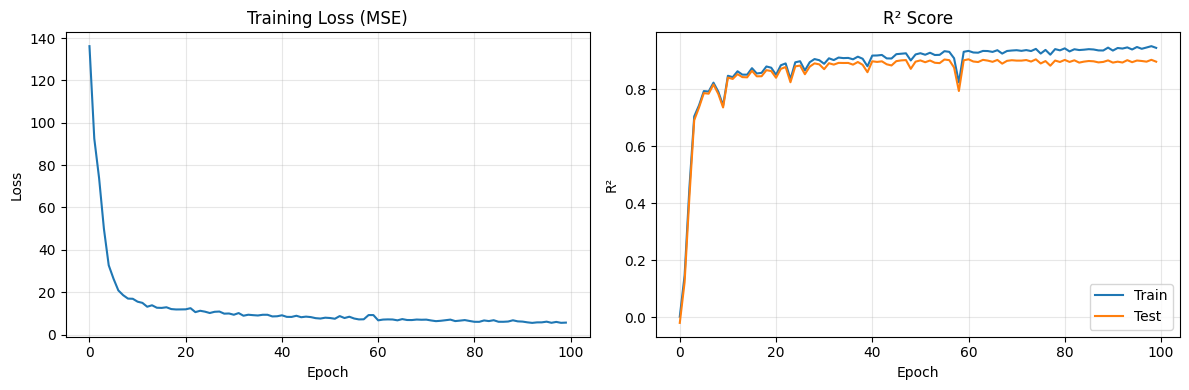

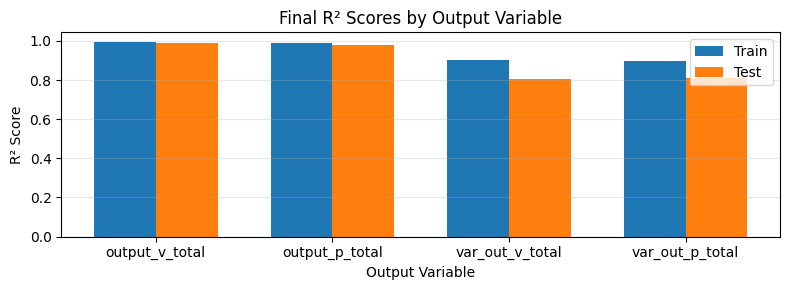

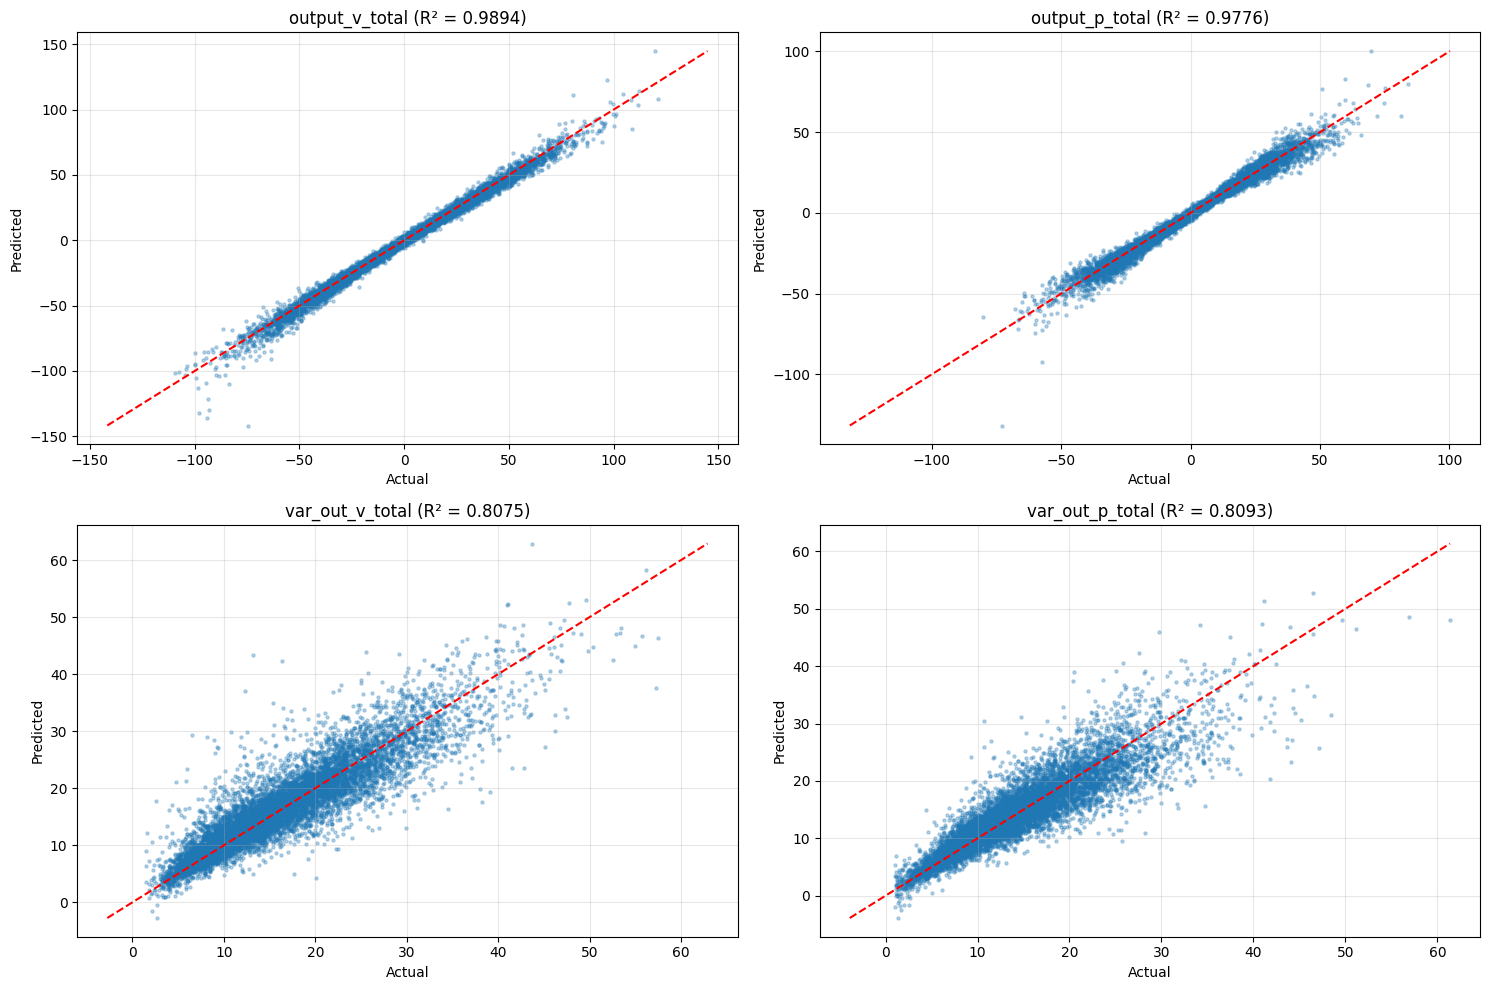

In [19]:

def Training(train_X, test_X, train_y, test_y):
    # Train the model
    model, results = train_and_evaluate_model(
        train_X, test_X, train_y, test_y,
        batch_size=256, hidden1_size=256, hidden2_size=128,
        learning_rate=0.001, num_epochs=100
    )
    
    # Visualize the results
    visualize_results(results, save_path="NN_results")
    
    # Save the model
    torch.save(model.state_dict(), "neural_integration_model.pth")
    print("\nModel saved to 'neural_integration_model.pth'")
    
    return model, results

if __name__ == "__main__":
    Training(train_X, test_X, train_y, test_y)